In [0]:
import torchvision
import torch
import numpy as np
from fastai.vision import *
from fastai import *
from torchvision import transforms

In [52]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [0]:


# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self, tensorboard=False):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.train_loader = None
    self.valid_loader = None

    self.tb = tensorboard

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, network, loader):

    self.run_start_time = time.time()

    self.run_count += 1

    self.network = network
    self.loader = loader

    if self.tb:
        self.tb = SummaryWriter(comment=f'-run')
        # images, labels = next(iter(self.train_loader))
        grid = torchvision.utils.make_grid(images)
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    if self.tb:
        self.tb.close()
        self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0


  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    if self.tb:
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    if self.tb:
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    # for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [0]:
import time

import numpy as np
import torch
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from matplotlib import pyplot as plt

from tqdm import tqdm

from PIL import Image


def prepare_loader(train_dir, test_dir, transform_train, test_transforms,
                   batch_size=64, test_size=0.2, num_workers=0):
    """
    Helper function for prepare data loader
    :param train_dir: train data directory
    :param test_dir: test data directory
    :param transform_train: train transform
    :param test_transforms: test transform
    :param batch_size: batch size, default 64
    :param test_size: test split percentage, default 20%
    :param num_workers: num of worker, default 0
    :return: train loader and test loader
    """

    # data set
    train_data = datasets.ImageFolder(train_dir, transform=transform_train)
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

    # obtain training indices that will be used for validation
    num_train = len(train_data)

    # mix data
    # index of num of train
    indices = list(range(num_train))
    # random the index
    np.random.shuffle(indices)
    split = int(np.floor(test_size * num_train))
    # divied into two part
    train_idx, test_idx = indices[split:], indices[:split]

    # define the sampler
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # prepare loaders
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size,
        sampler=test_sampler, num_workers=num_workers)

    print("Train size:{}".format(num_train))
    print("Test size:{}".format(len(test_data)))

    return [train_loader, test_loader]


def load_latest_model(model, name="model.pt"):
    """
    Helper function for Load model
    :param model: current model
    :param name: model name
    :return: loaded model default model.pt
    """
    model.load_state_dict(torch.load(name))
    return model


def save_current_model(model, name='model.pt'):
    """
    Helper function for save model
    :param model: current model
    :param name: model name, default model.pt
    :return: None
    """
    torch.save(model.state_dict(), name)


def save_check_point(model, epoch, train_loader, classes, optimizer, scheduler=None,
                     path=None, name='model.pt'):
    """
    Helper function for save check point. save everything like epoch
    optimizer state and also model state
    :param model: current model
    :param epoch: total epoch
    :param train_loader: train data loader for extract class_to_idx
    :param classes: total classes in your datasets
    :param optimizer: optimizer
    :param scheduler: scheduler if any, default None
    :param path: path for saving model, default None
    :param name: model name, default model.pt
    :return: None
    """

    class_to_idx = train_loader.dataset.class_to_idx

    try:
        classifier = model.classifier
    except AttributeError:
        classifier = model.fc

    checkpoint = {
        'class_to_idx': class_to_idx,
        'class_to_name': classes,
        'epochs': epoch,
        'classifier': classifier,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    if scheduler is not None:
        checkpoint['scheduler_state_dict'] = scheduler.state_dict()

    if path is None:
        d = model
    else:
        d = path + "/" + name

    torch.save(checkpoint, d)
    print(f"Model saved at {d}")


def load_checkpoint(path, model, optimizer_name='adam', lr=0.003, momentum=None,
                    scheduler=None, step=2, gamma=0.1):
    """
    Helper function for load check point
    :param path: path of saved model
    :param model: current model
    :param optimizer_name: optimizer name, default Adam
    :param lr: learning rate, used to create optimizer
    :param momentum: momentum if you use SGD optimizer, default None
    :param scheduler: StepLR scheduler, if you want to create scheduler, default None
    :param step: Period of learning rate decay, default 2
    :param gamma: Multiplicative factor of learning rate decay. default: 0.1
    :return: model, optimizer and scheduler(if scheduler is not None)
    """

    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False

    # Load in checkpoint
    if torch.cuda.is_available():
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location="cpu")

    # Extract classifier
    classifier = checkpoint['classifier']
    # set classifier
    try:
        check = model.classifier
    except AttributeError:
        check = False

    if check is not False:
        model.classifier = classifier
    else:
        model.fc = classifier

    # Extract others
    model.cat_to_name = checkpoint['class_to_name']
    model.class_to_idx = checkpoint['class_to_idx']
    model.epochs = checkpoint['epochs']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if optimizer_name.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        if momentum is not None:
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adadelta":
        optimizer = optim.Adadelta(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # load optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler is not None:
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')
    print(f'Model has been trained for {model.epochs} epochs.')

    if scheduler is not None:
        return [model, optimizer, scheduler]
    else:
        return [model, optimizer]


def freeze_parameters(model):
    """
    Helper function for freeze parameter
    :param model: current model
    :return: new model with freeze parameters
    """
    for param in model.parameters():
        param.requires_grad = False

    return model


def unfreeze(model):
    """
    Helper function for unfreeze parameters
    :param model: current model
    :return: new model with unfreeze parameters
    """
    for param in model.parameters():
        param.requires_grad = True

    return model


def train(model, train_loader, test_loader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pt", path=None):
    """
    Helper function for train model
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler: scheduler, default None
    :param name: model name, default model.pt
    :param path: model saved location, default None
    :return: model, list of train loss and test loss
    """

    m = RunManager()    
    # compare overfitted
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    m.begin_run(model, test_loader)
    
    for epoch in range(epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        if scheduler is not None:
            scheduler.step()  # step up scheduler
        
        for images, labels in tqdm(iterable=train_loader, total=len(train_loader)):
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)


        m.begin_epoch()
        ######################
        # validate the model #
        ######################
        # print("\n Going for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            m.track_loss(loss_p)
            m.track_num_correct(output, target)
        m.end_epoch()

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)


        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)


    m.end_run()
    # compare total time

    # return the model
    return [model, train_loss_data, valid_loss_data]


def train_faster_log(model, train_loader, test_loader,
                     epochs, optimizer, criterion, scheduler=None, print_every=5):
    """
    Helper function for train model. This model print log after a certain interval
    in every epoch.
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler scheduler, default None
    :param print_every: print log interval
    :return:
    """

    steps = 0
    running_loss = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        test_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch + 1}/{epochs}.. "
                      f"Train loss: {running_loss / print_every:.3f}.. "
                      f"Test loss: {test_loss / len(test_loader):.3f}.. "
                      f"Test accuracy: {accuracy / len(test_loader):.3f}")
                running_loss = 0
                model.train()

    if scheduler is not None:
        scheduler.step()

    return model


def check_overfitted(train_loss, test_loss):
    """
    Helper function for check over fitting
    :param train_loss: list of train loss
    :param test_loss: list of test loss
    :return: None
    """
    plt.plot(train_loss, label="Training loss")
    plt.plot(test_loss, label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(frameon=False)


def test_per_class(model, test_loader, criterion, classes):
    """
    Helper function for testing per class
    :param model: current model
    :param test_loader: test loader
    :param criterion: loss function
    :param classes: list of classes
    :return: None
    """

    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        
        for i in range(target.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))


def test(model, loader, criterion=None):
    """
    Helper function for test result. This function use torch.mean()
    :param model: current result
    :param loader: test data loader
    :param criterion: loss function to track loss, default None
    :return: None
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        model.eval()

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)

            if criterion is not None:
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    if criterion is not None:
        print("Test Loss:{:.6f}".format(test_loss),
              "\nAccuracy: {:.4f}".format(accuracy / len(loader) * 100))
    else:
        print("Accuracy: {:.4f}".format(accuracy / len(loader) * 100))

In [0]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [56]:
len(train_set)

60000

In [0]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image[0])
    plt.show()

def show(index, dataset, transforms=None):

    image = dataset[index][0]
    target = dataset[index][1]

    visualize(image=image)
    print('target is: ', target)

def show_random(dataset, transforms=None):
    length = len(dataset)
    index = random.randint(0, length - 1)
    show(index, dataset, transforms)

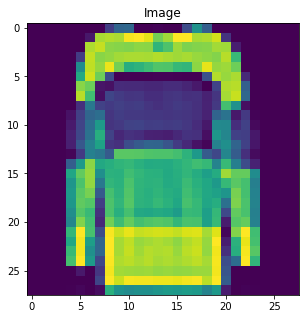

target is:  2


In [58]:
show_random(train_set)

In [0]:
class FashionDataSet(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [0]:
from sklearn.model_selection import train_test_split


def get_loaders(dataet, batch_size=128, train_transform=None, valid_transform=None):
    indices = np.arange(len(train_set))

    train_indeces, valid_indeces = train_test_split(indices, random_state=42)

    train_dataset = FashionDataSet(dataet, train_indeces, train_transform)
    valid_dataset = FashionDataSet(dataet, valid_indeces, valid_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=8
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=8
    )

    loaders = {
        'train': train_loader, 
        'valid': valid_loader
    }

    return loaders

In [0]:
# torchvision.models documentation recomendation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


loaders = get_loaders(
    train_set,
    batch_size=128,
    train_transform=None,
    valid_transform=None
)

In [0]:

class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    # self.conv1_dp = nn.Dropout() 
    # self.conv1_bn = nn.BatchNorm2d(num_features=6)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    # self.fc1_dp = nn.Dropout() 
    # self.fc1_bn = nn.BatchNorm1d(num_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    # t = self.conv1_dp(t)
    # t = self.conv1_bn(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    # t = self.fc1_dp(t)
    # t = self.fc1_bn(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)

    return t

In [0]:
model = Network()

device = torch.device('cuda')
model.to(device)

epoch = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()


train_loader = loaders['train']
valid_loader = loaders['valid']

In [77]:
model, train_loss, test_loss = train(model, train_loader, valid_loader, epoch, optimizer, criterion, path=None)

,run,epoch,loss,accuracy,epoch duration,run duration
0,1,1,0.480158,0.821333,1.622228,6.839874
1,1,2,0.410558,0.850733,1.678164,13.750110
2,1,3,0.383399,0.861800,1.666404,20.715991
3,1,4,0.371796,0.864133,1.622088,27.750661
4,1,5,0.362715,0.867067,1.637912,34.815892
5,1,6,0.397154,0.861133,1.600117,41.668633
6,1,7,0.339937,0.878800,1.636061,48.433888
7,1,8,0.361787,0.869200,1.616295,55.199541
8,1,9,0.337661,0.878800,1.647800,62.016709
9,1,10,0.350296,0.873667,1.607516,68.679837


In [0]:
model = load_latest_model(model)

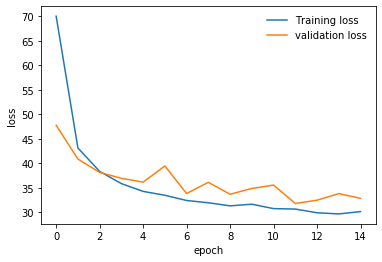

In [79]:
check_overfitted(train_loss, test_loss)

In [80]:
test(model, valid_loader)

Accuracy: 88.5483


In [81]:
test_per_class(model, valid_loader, criterion, np.arange(10))

Test Loss: 0.317749

Test Accuracy of     0: 81% (1205/1486)
Test Accuracy of     1: 97% (1507/1546)
Test Accuracy of     2: 83% (1249/1499)
Test Accuracy of     3: 91% (1356/1484)
Test Accuracy of     4: 81% (1234/1515)
Test Accuracy of     5: 95% (1422/1493)
Test Accuracy of     6: 67% (1014/1505)
Test Accuracy of     7: 95% (1408/1476)
Test Accuracy of     8: 96% (1445/1500)
Test Accuracy of     9: 96% (1439/1496)

 Test Accuracy (Overall): 88% (13279/15000)
